# 숙명여자대학교 Deep Learning 2024 수업 Lab 5: Visualization

# Visualize the trained weights

## Import Library
TensorFlow and its submodules: tf, numpy (as np), keras

Specific layers and utilities from Keras:
Sequential, Conv2D, MaxPooling2D, Flatten, Dense
matplotlib.pyplot for visualization
cv2 (OpenCV) for image processing

PyTorch and its submodules torch and torchvision for tensor operations and image visualization.


Matplotlib for displaying the weights as an image.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision

## Loading the ResNet50 model:

The ResNet50 function from tf.keras.applications.resnet50 is used to load the pre-trained ResNet50 model.

**The model is initialized with the following parameters:**

input_shape=None: The input shape of the model is not specified, allowing it to accept inputs of any size.

include_top=False: The fully connected layers at the top of the model, which are responsible for classification, are excluded.

weights='imagenet': The weights of the pre-trained ResNet50 model trained on the ImageNet dataset are used.


In [2]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step



## Accessing and manipulating the weights:

The code retrieves the weights from the second layer (base_model.layers[2].weights[0].numpy()).

The shape of the weights is printed (weights.shape).
The weights are converted to a PyTorch tensor (torch.tensor(weights)).

The dimensions of the tensor are permuted to match the PyTorch format (permute((3, 2, 0, 1))).

The absolute square root of the weights is calculated (torch.sqrt(torch.abs(weights))).

The weights are converted into a grid format (torchvision.utils.make_grid(weights, normalize=True, scale_each=True)).

In [3]:
weights = base_model.layers[2].weights[0].numpy()
print(weights.shape)
weights = torch.tensor(weights).permute((3,2,0,1))
weights = torch.sqrt(torch.abs(weights))
weights = torchvision.utils.make_grid(weights,normalize=True, scale_each=True)
print(weights.shape)
c, h, w = weights.shape
weights = weights.permute((1, 2, 0))
print(weights.shape)

(7, 7, 3, 64)
torch.Size([3, 74, 74])
torch.Size([74, 74, 3])


## Visualizing the weights:

The shape of the weights is printed (weights.shape).
The dimensions of the weights tensor are permuted for visualization (permute((1, 2, 0))).
Matplotlib's imshow() function is used to display the weights as an image (plt.imshow(weights)).

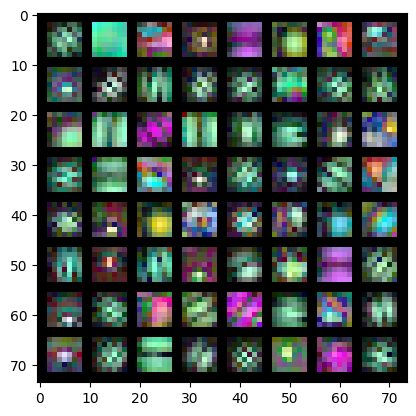

In [4]:
plt.imshow(weights)

# Class Activation Maps with MNIST

This code tutorial demonstrates how to use a trained Convolutional Neural Network (CNN) to generate Class Activation Maps (CAM) for image classification. Here is a breakdown of the code:

## Load MNIST and Creating the CNN model

The MNIST dataset is a collection of handwritten digit images used for training and testing the model.
The data is split into training and testing sets, and they are assigned to the variables X_train, Y_train, X_test, and Y_test.



In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


# Define the PyTorch model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net()
model.to(device)  # Move the model to the GPU
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


## Training the model

Train the model using the training data (X_train and Y_train). The number of epochs is set to 8.


In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
model.train()
for epoch in range(8):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Epoch 1, Loss: 1.4403154856360543
Epoch 2, Loss: 0.74238063563416
Epoch 3, Loss: 0.515885675290246
Epoch 4, Loss: 0.39526632815790075
Epoch 5, Loss: 0.3244625965176996
Epoch 6, Loss: 0.2794941449438585
Epoch 7, Loss: 0.2528840196388426
Epoch 8, Loss: 0.22913471678458552
Accuracy of the network on the 10000 test images: 94.48%


In [32]:
# prompt: use torchsummary to show the shape of outputs of each layer
from torchsummary import summary

model.to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                   [-1, 10]             650
Total params: 19,466
Trainable params: 19,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.07
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


## Extracting specific layers from the model

The code demonstrates how to retrieve the third layer (max pooling layer) and the weights of the fifth layer (fully connected layer) from the model.


**Generating the Class Activation Map (CAM)**:

CAM is computed by performing matrix multiplication between the output of the max pooling layer and the weights of the fully connected layer.
A new model (CAM) is created with the same inputs as the original model but with the output set as the CAM.


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hook for the features of the conv layer
features_blobs = []

def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

# Register hook
model.conv2.register_forward_hook(hook_feature)

# Weights of the fully connected layer
params = list(model.parameters())
print(model)
print('model parameter list: ', len(list(model.parameters())))
print('fc weight shape: ', params[-2].shape)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)
model parameter list:  6
fc weight shape:  torch.Size([10, 64])


In [75]:
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

# Test
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)  # Batch size set to 1 for demo
model.eval()
test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
output = model(test_images)

_, pred = torch.max(output, 1)
pred = pred.data.cpu().numpy()
print('pred: ', pred)

# Generate CAM
feature_conv = features_blobs[0]
class_idx = [pred[0]]

print(f'shape of feature_conv: {feature_conv.shape}, weight_softmax: {weight_softmax.shape}')

pred:  [8]
shape of feature_conv: (1, 64, 14, 14), weight_softmax: (10, 64)



## Visualizing the CAM:

A specific test image is selected (test_image) from the test set for visualization.

The model predicts the class label (pred) for the test image and generates the CAM (predCAM).
The CAM is processed and resized using OpenCV to match the size of the test image.

Matplotlib is used to create a figure with multiple subplots to display the original image, the CAM, the resized original image, the resized CAM, and a combination of the resized image and CAM.
The figure is displayed using plt.show().
This code tutorial provides a step-by-step explanation of how to train a CNN model, extract specific layers, generate Class Activation Maps, and visualize them using the MNIST dataset. It combines TensorFlow, Keras, OpenCV, and Matplotlib to showcase these concepts.

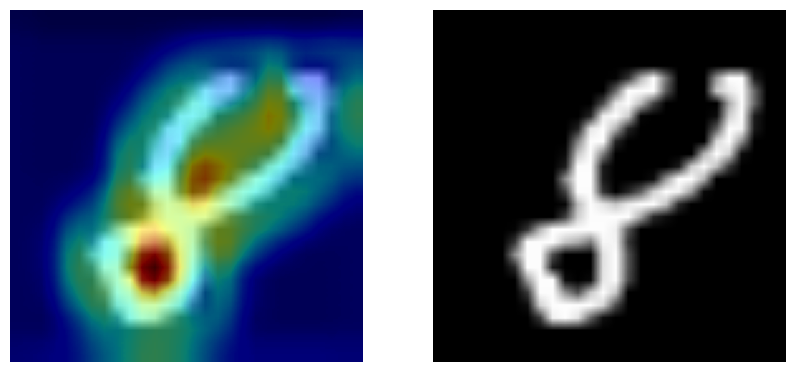

In [76]:
# Generate the class activation maps
size_upsample = (28, 28)
bz, nc, h, w = feature_conv.shape
output_cam = []
for idx in class_idx:
    cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output_cam.append(cv2.resize(cam_img, size_upsample))
CAMs = output_cam


# Display results
img = test_images[0].data.cpu().numpy()
img = np.moveaxis(img, 0, -1).squeeze()
img = (img * 255).astype(np.uint8)

height, width = 28 * 5, 28 * 5  # Scaling factors

# Resize images for display
resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
resized_cam = cv2.resize(CAMs[0], (width, height), interpolation=cv2.INTER_LINEAR)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(resized_img, cmap='gray')
ax[0].imshow(resized_cam, cmap='jet', alpha=0.5)
ax[0].axis('off')

ax[1].imshow(resized_img, cmap='gray')
ax[1].axis('off')
plt.show()
